# SVI Smile Section

The Stochastic Volatility Inspired (SVI) model is a popular parametric form for volatility smiles. This notebook demonstrates:

1. Using `SviSmileSection` and understanding parameter effects
2. Pure Python implementation via `pyquantlib.extensions`
3. Benchmarking Python vs C++ implementations

In [ ]:
import pyquantlib as ql
import numpy as np
import matplotlib.pyplot as plt

print(f"PyQuantLib {ql.__version__} (QuantLib {ql.QL_VERSION})")

---

## 1. The SVI Formula

SVI parametrizes **total variance** $w(k) = \sigma^2 T$ as a function of log-moneyness $k = \log(K/F)$:

$$w(k) = a + b \left( \rho (k - m) + \sqrt{(k - m)^2 + \sigma^2} \right)$$

**Parameters:**
- `a`: Vertical translation (overall variance level)
- `b`: Slope of the wings ($b \geq 0$)
- `sigma`: ATM curvature ($\sigma > 0$)
- `rho`: Rotation/skew ($-1 < \rho < 1$)
- `m`: Horizontal translation (shifts the smile left/right)

In [3]:
# Basic SVI smile section
T = 1.0       # 1 year to expiry
F = 100.0     # Forward price

# SVI parameters: [a, b, sigma, rho, m]
params = [0.04, 0.1, 0.3, -0.4, 0.0]

smile = ql.SviSmileSection(T, F, params)

print(f"ATM level (forward): {smile.atmLevel()}")
print(f"ATM volatility: {smile.volatility(F):.4f}")
print(f"Strike range: [{smile.minStrike()}, {smile.maxStrike():.0e}]")

ATM level (forward): 100.0
ATM volatility: 0.2646
Strike range: [0.0, 2e+308]


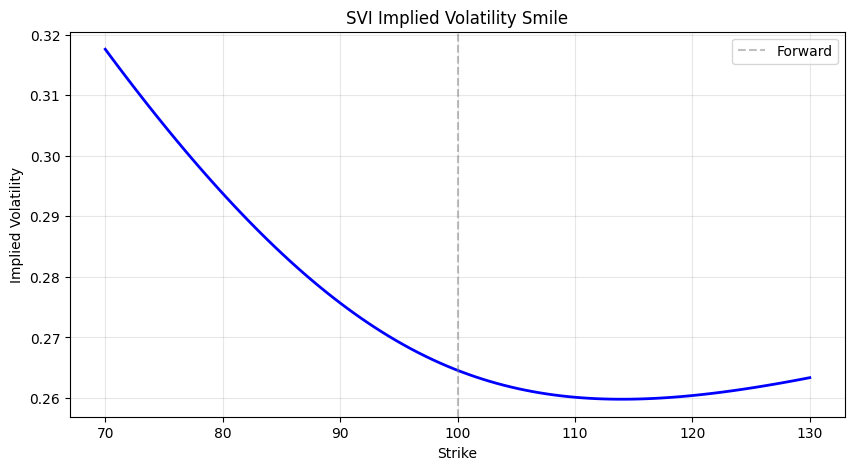

In [4]:
# Plot the smile
strikes = np.linspace(70, 130, 100)
vols = [smile.volatility(K) for K in strikes]

plt.figure(figsize=(10, 5))
plt.plot(strikes, vols, 'b-', linewidth=2)
plt.axvline(F, color='gray', linestyle='--', alpha=0.5, label='Forward')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('SVI Implied Volatility Smile')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---

## 2. Parameter Effects

The following visualizations show how each parameter affects the smile shape.

In [5]:
def plot_svi_smiles(param_name, param_values, base_params, param_idx):
    """Plot SVI smiles varying one parameter."""
    strikes = np.linspace(70, 130, 100)
    
    plt.figure(figsize=(10, 5))
    
    for val in param_values:
        params = base_params.copy()
        params[param_idx] = val
        
        try:
            smile = ql.SviSmileSection(1.0, 100.0, params)
            vols = [smile.volatility(K) for K in strikes]
            plt.plot(strikes, vols, linewidth=2, label=f'{param_name}={val}')
        except Exception as e:
            print(f"Invalid params for {param_name}={val}: {e}")
    
    plt.axvline(100, color='gray', linestyle='--', alpha=0.5)
    plt.xlabel('Strike')
    plt.ylabel('Implied Volatility')
    plt.title(f'Effect of {param_name} on SVI Smile')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

### 2.1 Parameter `a` - Vertical Translation

Controls the overall level of variance. Higher `a` shifts the entire smile up.

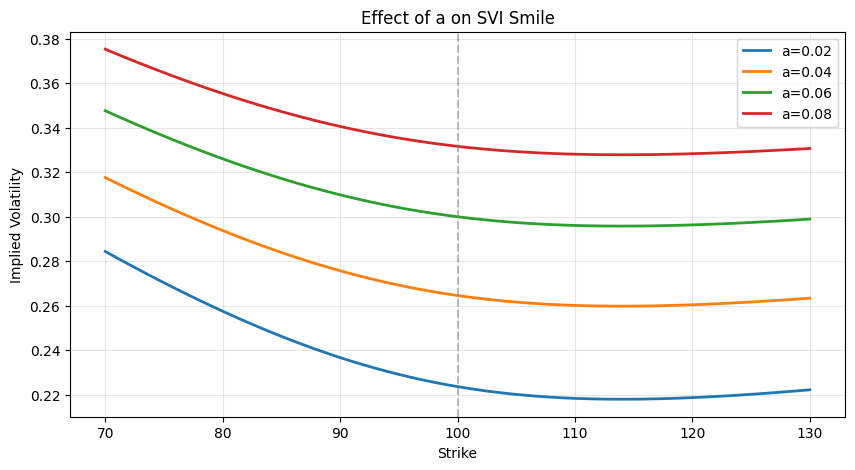

In [6]:
base = [0.04, 0.1, 0.3, -0.4, 0.0]
plot_svi_smiles('a', [0.02, 0.04, 0.06, 0.08], base, 0)

### 2.2 Parameter `b` - Wing Slope

Controls how steeply volatility increases in the wings. Higher `b` means steeper wings.

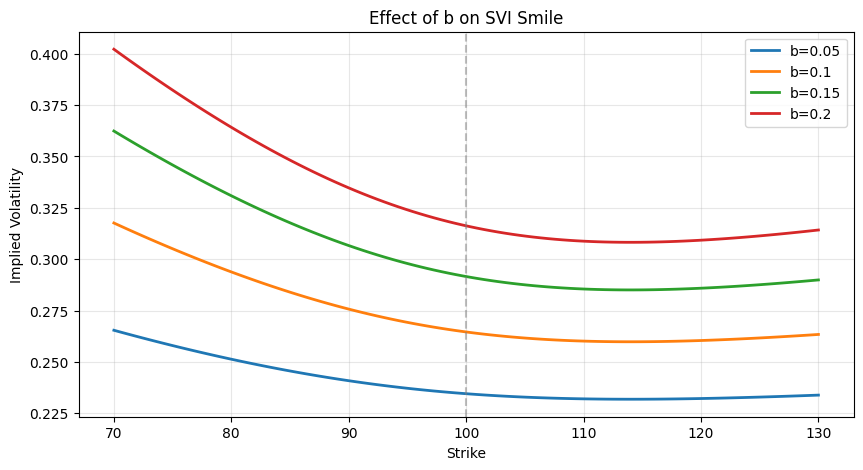

In [7]:
base = [0.04, 0.1, 0.3, -0.4, 0.0]
plot_svi_smiles('b', [0.05, 0.10, 0.15, 0.20], base, 1)

### 2.3 Parameter `sigma` - ATM Curvature

Controls the curvature at the money. Smaller `sigma` gives a sharper V-shape; larger `sigma` gives a smoother U-shape.

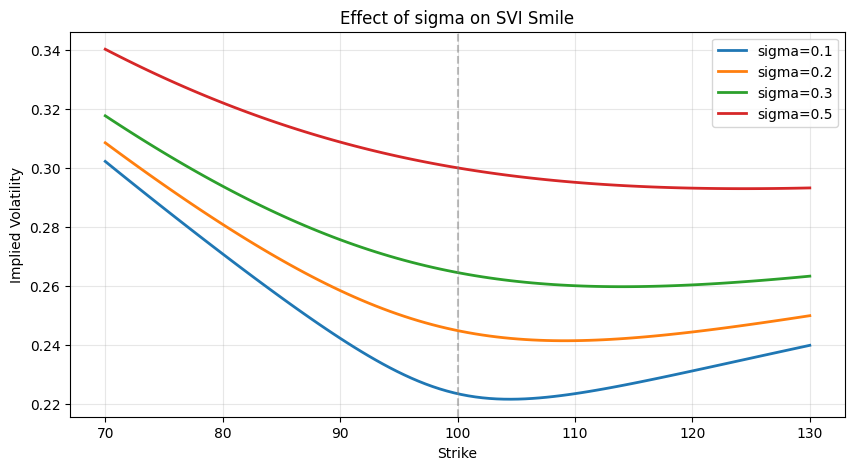

In [8]:
base = [0.04, 0.1, 0.3, -0.4, 0.0]
plot_svi_smiles('sigma', [0.1, 0.2, 0.3, 0.5], base, 2)

### 2.4 Parameter `rho` - Skew/Rotation

Controls the asymmetry of the smile:
- `rho < 0`: Downside skew (puts more expensive) - typical for equities
- `rho = 0`: Symmetric smile
- `rho > 0`: Upside skew (calls more expensive)

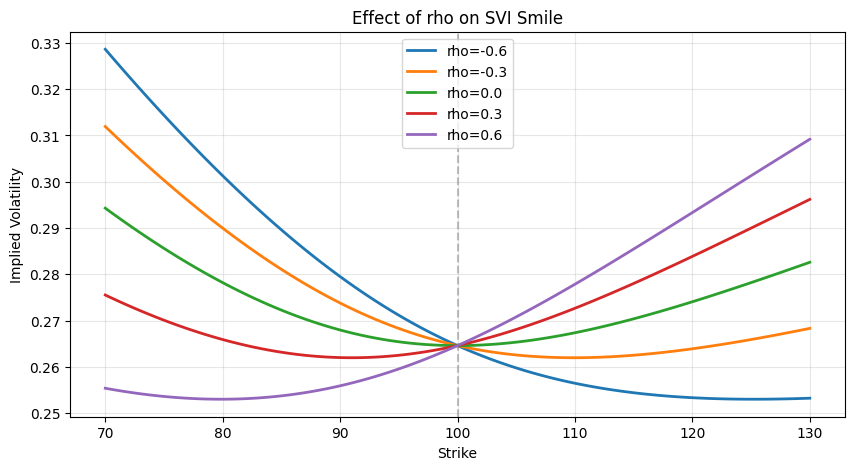

In [9]:
base = [0.04, 0.1, 0.3, 0.0, 0.0]
plot_svi_smiles('rho', [-0.6, -0.3, 0.0, 0.3, 0.6], base, 3)

### 2.5 Parameter `m` - Horizontal Translation

Shifts the smile left or right along the strike axis. This moves the minimum of the smile away from ATM.

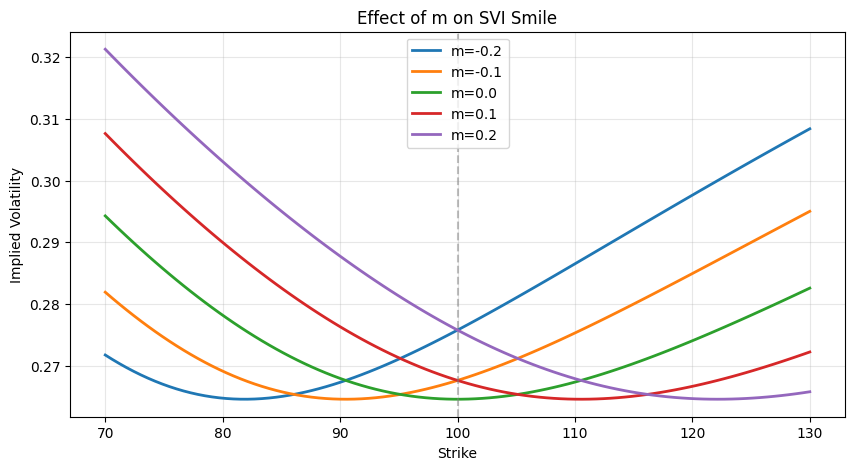

In [10]:
base = [0.04, 0.1, 0.3, 0.0, 0.0]  # rho=0 for symmetric base
plot_svi_smiles('m', [-0.2, -0.1, 0.0, 0.1, 0.2], base, 4)

---

## 3. No-Arbitrage Constraints

SVI parameters must satisfy certain constraints to avoid arbitrage:

- $b \geq 0$
- $|\rho| < 1$
- $\sigma > 0$
- $a + b\sigma\sqrt{1-\rho^2} \geq 0$ (non-negative variance)
- $b(1 + |\rho|) \leq 4$ (butterfly arbitrage)

Use `checkSviParameters()` to validate:

In [11]:
# Valid parameters
try:
    ql.checkSviParameters(0.04, 0.1, 0.3, -0.4, 0.0, 1.0)
    print("Parameters are valid!")
except ql.Error as e:
    print(f"Invalid: {e}")

Parameters are valid!


In [12]:
# Invalid: b < 0
try:
    ql.checkSviParameters(0.04, -0.1, 0.3, -0.4, 0.0, 1.0)
except ql.Error as e:
    print(f"Invalid: {e}")

Invalid: b (-0.1) must be non negative


---

## 4. SmileSection Interface

`SviSmileSection` inherits from `SmileSection`, providing option pricing and greeks:

In [13]:
smile = ql.SviSmileSection(0.5, 100.0, [0.04, 0.1, 0.3, -0.4, 0.0])

K = 105  # OTM call strike

print(f"Strike: {K}")
print(f"Volatility: {smile.volatility(K):.4f}")
print(f"Variance: {smile.variance(K):.6f}")
print(f"Call price: {smile.optionPrice(K, ql.OptionType.Call):.4f}")
print(f"Put price: {smile.optionPrice(K, ql.OptionType.Put):.4f}")
print(f"Vega: {smile.vega(K):.4f}")
print(f"Density: {smile.density(K):.6f}")

Strike: 105
Volatility: 0.3700
Variance: 0.068443
Call price: 8.3513
Put price: 13.3513
Vega: 0.2817
Density: 0.016230


---

## 5. Pure Python Implementation

The `SviSmileSection` in `pyquantlib.extensions` is a pure Python implementation that subclasses `SmileSection`:

In [14]:
from pyquantlib.extensions import SviSmileSection

# Pure Python implementation
py_smile = SviSmileSection(1.0, 100.0, [0.04, 0.1, 0.3, -0.4, 0.0])

print(f"ATM vol (Python): {py_smile.volatility(100.0):.6f}")
print(f"90 strike vol:    {py_smile.volatility(90.0):.6f}")
print(f"110 strike vol:   {py_smile.volatility(110.0):.6f}")

ATM vol (Python): 0.264575
90 strike vol:    0.275701
110 strike vol:   0.260125


### 5.1 Benchmark: Python vs C++

Since `ql.SviSmileSection` exists in QuantLib's experimental folder, the Python implementation can be benchmarked against it:

In [15]:
# C++ implementation (QuantLib experimental)
cpp_smile = ql.SviSmileSection(1.0, 100.0, [0.04, 0.1, 0.3, -0.4, 0.0])

# Python implementation (pyquantlib extension)
py_smile = SviSmileSection(1.0, 100.0, [0.04, 0.1, 0.3, -0.4, 0.0])

# Compare across strike range
strikes = [80, 90, 95, 100, 105, 110, 120]

print("Strike | C++ Vol    | Python Vol | Diff (bps)")
print("-" * 50)
for K in strikes:
    cpp_vol = cpp_smile.volatility(K)
    py_vol = py_smile.volatility(K)
    diff_bps = (py_vol - cpp_vol) * 10000
    print(f"{K:6.0f} | {cpp_vol:.8f} | {py_vol:.8f} | {diff_bps:+.4f}")

Strike | C++ Vol    | Python Vol | Diff (bps)
--------------------------------------------------
    80 | 0.29379355 | 0.29379355 | +0.0000
    90 | 0.27570052 | 0.27570052 | +0.0000
    95 | 0.26923424 | 0.26923424 | +0.0000
   100 | 0.26457513 | 0.26457513 | +0.0000
   105 | 0.26161527 | 0.26161527 | +0.0000
   110 | 0.26012537 | 0.26012537 | +0.0000
   120 | 0.26040902 | 0.26040902 | +0.0000


### 5.2 Visual Comparison

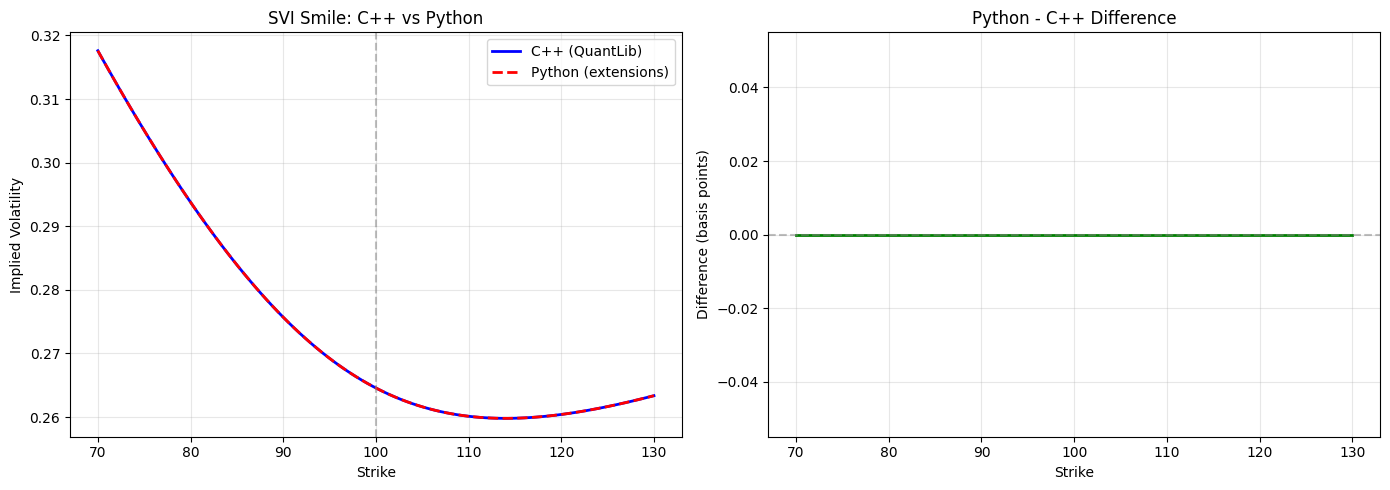

Max absolute difference: 0.000000 bps


In [16]:
strikes = np.linspace(70, 130, 100)
cpp_vols = [cpp_smile.volatility(K) for K in strikes]
py_vols = [py_smile.volatility(K) for K in strikes]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Overlay plot
ax1.plot(strikes, cpp_vols, 'b-', linewidth=2, label='C++ (QuantLib)')
ax1.plot(strikes, py_vols, 'r--', linewidth=2, label='Python (extensions)')
ax1.axvline(100, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('Strike')
ax1.set_ylabel('Implied Volatility')
ax1.set_title('SVI Smile: C++ vs Python')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Difference plot (in basis points)
diff_bps = [(py - cpp) * 10000 for py, cpp in zip(py_vols, cpp_vols)]
ax2.plot(strikes, diff_bps, 'g-', linewidth=2)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Strike')
ax2.set_ylabel('Difference (basis points)')
ax2.set_title('Python - C++ Difference')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Max absolute difference: {max(abs(d) for d in diff_bps):.6f} bps")

### 5.3 Performance Comparison

For closed-form formulas like SVI, Python performance is comparable to C++:

In [17]:
import time

strikes = np.linspace(70, 130, 1000)
n_iterations = 100

# C++ timing
start = time.perf_counter()
for _ in range(n_iterations):
    for K in strikes:
        cpp_smile.volatility(K)
cpp_time = time.perf_counter() - start

# Python timing
start = time.perf_counter()
for _ in range(n_iterations):
    for K in strikes:
        py_smile.volatility(K)
py_time = time.perf_counter() - start

print(f"C++ time:    {cpp_time:.3f}s ({n_iterations * len(strikes):,} calls)")
print(f"Python time: {py_time:.3f}s ({n_iterations * len(strikes):,} calls)")
print(f"Ratio:       {py_time/cpp_time:.2f}x")

C++ time:    0.140s (100,000 calls)
Python time: 0.733s (100,000 calls)
Ratio:       5.24x


### 5.4 Extending in Python

The real power is rapid prototyping. The formula can be easily modified or variants tested:

In [18]:
import math
from pyquantlib.base import SmileSection

class MySviVariant(SmileSection):
    """Custom SVI variant - can be modified here."""
    
    def __init__(self, T, F, params):
        super().__init__()
        self._T = T
        self._F = F
        self._a, self._b, self._sigma, self._rho, self._m = params
    
    def minStrike(self):
        return 0.0
    
    def maxStrike(self):
        return float('inf')
    
    def atmLevel(self):
        return self._F
    
    def volatilityImpl(self, strike):
        k = math.log(strike / self._F)
        # Standard SVI formula - can be modified as needed
        w = self._a + self._b * (
            self._rho * (k - self._m) + 
            math.sqrt((k - self._m)**2 + self._sigma**2)
        )
        return math.sqrt(max(w, 1e-10) / self._T)

# Test custom implementation
custom = MySviVariant(1.0, 100.0, [0.04, 0.1, 0.3, -0.4, 0.0])
print(f"Custom ATM vol: {custom.volatility(100.0):.6f}")
print(f"C++ ATM vol:    {cpp_smile.volatility(100.0):.6f}")

Custom ATM vol: 0.264575
C++ ATM vol:    0.264575
